In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score

from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("mnist")
train_data = dataset["train"]
test_data = dataset["test"]


Found cached dataset mnist (C:/Users/HP/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)


  0%|          | 0/2 [00:00<?, ?it/s]

The next few blocks are more me playing around and figuring out tensorflow without changeing the image inputs

In [5]:
# this lets you see some of the input images
num_samples = 0        
for i in range(num_samples):
    image = train_data[i]["image"]
    label = train_data[i]["label"]
    
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.show()

In [6]:
# only processing traing data need to do to rest when testing
input_data = np.zeros((len(train_data), 28, 28, 1))
what_num = np.array([-1]*len(train_data))

for i in range(len(train_data)):
    image = train_data[i]["image"]
    what_num[i] = train_data[i]["label"]
    input_data[i] = np.expand_dims(image, axis=-1) / 255.0  

input_data = input_data.reshape(-1, 28, 28, 1)
print("Input data shape:", input_data.shape)

Input data shape: (60000, 28, 28, 1)


In [7]:
#creates the model
model = tf.keras.models.Sequential()
#from tf.keras.layers import Dense

model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))   # what about the -1 in the beginin? want to check how differs from input_data shape
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax')) # should play aroud more with the activation functions

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



In [8]:
invalid_labels = np.logical_or(what_num < 0, what_num >= 10)
# Remove invalid label values
input_data = input_data[~invalid_labels]
what_num = what_num[~invalid_labels]

# Verify the updated shapes
print("Updated input data shape:", input_data.shape)
print("Updated target labels shape:", what_num.shape)

Updated input data shape: (60000, 28, 28, 1)
Updated target labels shape: (60000,)


In [9]:
model.fit(input_data, what_num, epochs=20, batch_size=32)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6534 - accuracy: 0.8364
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3332 - accuracy: 0.9077
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2836 - accuracy: 0.9205
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2531 - accuracy: 0.9293
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2306 - accuracy: 0.9359
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2119 - accuracy: 0.9412
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1965 - accuracy: 0.9456
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1832 - accuracy: 0.9492
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1717 - accuracy: 0.9517
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.161

In [10]:
#formating the test data
input_data_test = np.zeros((len(test_data), 28, 28, 1))
what_num_test = np.array([-1] * len(test_data))

for i in range(len(test_data)):
    image = test_data[i]["image"]
    what_num_test[i] = test_data[i]["label"]
    input_data_test[i] = np.expand_dims(image, axis=-1) / 255.0

input_data_test = input_data_test.reshape(-1, 28, 28, 1)



In [11]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(input_data_test, what_num_test)
print('Testing Loss:', test_loss)
print('Testing Accuracy:', test_accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.1120 - accuracy: 0.9665
Testing Loss: 0.11204924434423447
Testing Accuracy: 0.9664999842643738


In [12]:
from PIL import Image

def display_image(array):
    # Display the black and white image
    plt.imshow(array*255, cmap="gray")
    plt.title("Black and White Image")
    plt.show()
    

In [13]:
image = Image.open('test_image.png')
img_array = np.array(image)  
personal_img = np.expand_dims(img_array, axis=0) / 255.0  


prediction = model.predict(personal_img)
predicted_label = np.argmax(prediction)
print("Predicted Label:", predicted_label)

1/1 [==============================] - 0s 117ms/step
Predicted Label: 3


In [14]:
#tf.saved_model.save(model, "nn_number_model")

In [15]:
# this is how i rotate the nummber on the image
from scipy.ndimage import rotate

def rotate_array(input_array, angle):
    rotated_array = rotate(input_array, angle, reshape=False, mode='constant', cval=0.0, order=1)

    return rotated_array


In [16]:
from scipy.ndimage import zoom

def modify_border(array, num_pixels):
    array = np.array(array)
    if num_pixels ==0:
        return array
    
    if array.ndim == 2:
        array = np.expand_dims(array, axis=-1)
        
    height, width, channels = array.shape
    new_height = height + 2 * abs(num_pixels)
    new_width = width + 2 * abs(num_pixels)

    new_array = np.zeros((new_height, new_width, channels), dtype=array.dtype)

    if num_pixels > 0:
        new_array[num_pixels:num_pixels + height, num_pixels:num_pixels + width, :] = array
    elif num_pixels < 0:
        new_array = array[abs(num_pixels):-abs(num_pixels), abs(num_pixels):-abs(num_pixels), :]

    return resize_image(new_array)



from skimage.transform import resize

def resize_image(image):
    image_array = np.array(image)
    scale_factor = 28 / image.shape[0]
    new_height = int(image_array.shape[0] * scale_factor)
    new_width = int(image_array.shape[1] * scale_factor)
    resized_image = resize(image_array, (new_height, new_width), anti_aliasing=True)

    return resized_image


#                                          i like -2 (make bigger) to 12 for really small
# # Add outer border (all zeros)
# result_image_add = add_or_remove_outer_border(input_image, -2)
# print("Image with added outer border:")
# print(display_image(result_image_add))

# # Remove outer border (all zeros)
# result_image_remove =  add_or_remove_outer_border(input_image, 12)
# print("Image with removed outer border:")
# print(display_image(result_image_remove))


In [17]:
def shift_image(image, x_offset, y_offset):
    image_array = np.array(image)
    height, width, channels = image_array.shape
    shifted_image = np.zeros((height, width, channels), dtype=image_array.dtype)

    x_start = max(0, x_offset)
    x_end = min(width, width + x_offset)
    y_start = max(0, y_offset)
    y_end = min(height, height + y_offset)

    shifted_image[y_start:y_end, x_start:x_end, :] = image_array[y_start - y_offset:y_end - y_offset, x_start - x_offset:x_end - x_offset, :]

    return shifted_image

# will try to do 4 in each direction

# resized_image = shift_image(input_image, x_offset, y_offset)
# print("Resized Image:")
# print(display_image(resized_image))


In [18]:
def add_random_pixel_noise(image, num_pixels, new_value):
    image_array = np.array(image)
    height, width, channels = image_array.shape
    flattened_image = image_array.flatten()

    selected_indices = np.random.choice(len(flattened_image), size=num_pixels, replace=False)
    flattened_image[selected_indices] = new_value
    noisy_image = flattened_image.reshape(height, width, channels)

    return noisy_image

#noisy_image = add_random_pixel_noise(noisy_image, 5, .9)
#print("Noisy Image:")
#print(display_image(noisy_image))


In [19]:
import random as r

def change_image(array):
    angle = r.randint(-12, 12) #12 - -12
    array = rotate_array(array, angle)   
    num_pix = r.randint(-2, 12)
    array = modify_border(array, num_pix)
    x_offset,  y_offset = r.randint(-4,4), r.randint(-4,4)
    array = shift_image(array, x_offset, y_offset)  # 4- -4 , 4-4 
    num_pixs = r.randint(0, 20)
    array = add_random_pixel_noise(array, num_pixs, .5) #  0-30 .5
    return array



In [20]:
#display_image(change_image(input_data[6]))

In [21]:
modified_data = np.zeros((len(train_data), 28, 28, 1))
modified_data_2 = np.zeros((len(train_data), 28, 28, 1))
modified_data_3 = np.zeros((len(train_data), 28, 28, 1))           # it worked with one but why not three instead and less epocs

for i in range(len(input_data)):
    modified_data[i] = change_image(input_data[i])
    modified_data_2[i] = change_image(input_data[i])
    modified_data_3[i] = change_image(input_data[i])
    


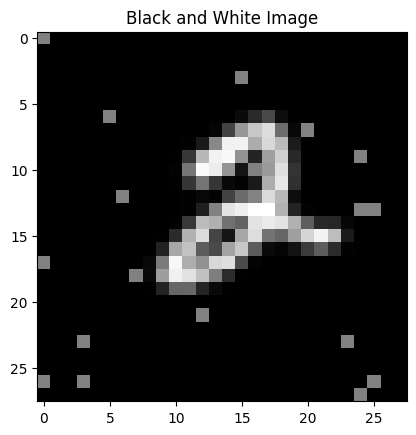

6


In [33]:
all_data = np.concatenate((modified_data, modified_data_2, modified_data_3), axis=0)
all_nums = np.concatenate((what_num, what_num, what_num), axis=0)

display_image(all_data[5])
print(what_num[5632])

In [34]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))  
model.add(tf.keras.layers.Dense(units=256, activation='relu'))    # might what to play around with the second layer of inputs here. is more always safer?
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


In [35]:
model.fit(all_data, all_nums, epochs=100, batch_size=32) # 32 more or less. sounds jsut like a defult

Epoch 1/100
5625/5625 [==============================] - 17s 3ms/step - loss: 1.8126 - accuracy: 0.4051
Epoch 2/100
5625/5625 [==============================] - 16s 3ms/step - loss: 1.1850 - accuracy: 0.6541
Epoch 3/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.8923 - accuracy: 0.7469
Epoch 4/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.7330 - accuracy: 0.7950
Epoch 5/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.6346 - accuracy: 0.8227
Epoch 6/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.5677 - accuracy: 0.8430
Epoch 7/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.5186 - accuracy: 0.8573
Epoch 8/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.4806 - accuracy: 0.8674
Epoch 9/100
5625/5625 [==============================] - 16s 3ms/step - loss: 0.4501 - accuracy: 0.8766
Epoch 10/100
5625/5625 [==============================] - 16s 3m

In [36]:
tf.saved_model.save(model, "nn_mach_3")

INFO:tensorflow:Assets written to: nn_mach_3\assets


INFO:tensorflow:Assets written to: nn_mach_3\assets
